In [1]:
import os
import sys

import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

from torchviz import make_dot
import matplotlib.pyplot as plt
import graphviz

from pathlib import Path
from userHelper import *


# Model Specifics
# import pytorch_resnet as R
import BaseModel as B
import CDDSM
from tqdm import tqdm



#Device Selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 4
learning_rate = 0.001

def pause(strg):
    if(strg!=''):
        print('Reached at {}, Press any key to continue'.format(strg))
    else:
        print('Paused, Press any to continue')
    input()
    return

# x = torch.randn(batch_size, channels_mammo,heights_mammo , width_mammo)

# Reading Standard CSV files by TCIA for test/train

In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'
num_epochs = 100
num_classes = 3
batch_size = 2
learning_rate = 0.0001

total_iteration = 10000
img_resize =H=W=512


homedir = str(Path.home())
homedir

train_df = CDDSM.createTrainFrame(homedir)
test_df = CDDSM.createTestFrame(homedir)
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_file = mammogram_dir+'train.csv'
test_file = mammogram_dir+'test.csv'
train_df.to_csv(train_file)
test_df.to_csv(test_file)

classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')
                

# Making of CBIS-DDSM Dataset (train,val,test)

In [3]:
dataset =  CDDSM.MammographyDataset(train_file,homedir,img_resize)
test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)

train_dataset , val_dataset = CDDSM.trainValSplit(dataset,val_share=0.98)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Length of each Dataset

In [4]:
numberOfTrainData = train_dataset.__len__()
numberOfValData = val_dataset.__len__()
numberOfTestData =  test_dataset.__len__()

total_step=len(train_loader)

print('Size of training dataset {}'.format(numberOfTrainData))
print('Size of Validation dataset {}'.format(numberOfValData))
print('Size of testing dataset {}'.format(numberOfTestData))
print('No. of Epochs: {}\n Batch size: {}\n Learning_rate : {}\n Image size {}*{}\n Step {}'
        .format(num_epochs,batch_size,learning_rate,H,W,total_step))

Size of training dataset 57
Size of Validation dataset 2807
Size of testing dataset 704
No. of Epochs: 100
 Batch size: 2
 Learning_rate : 0.0001
 Image size 512*512
 Step 29


# Checking images in each dataset by making grid

# trainDataset

BENIGN BENIGN


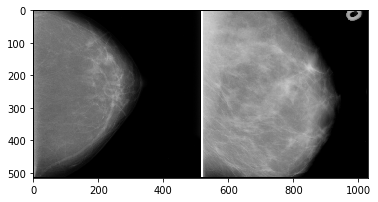

In [5]:
trainloader = train_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# val Dataset

BENIGN_WITHOUT_CALLBACK BENIGN_WITHOUT_CALLBACK


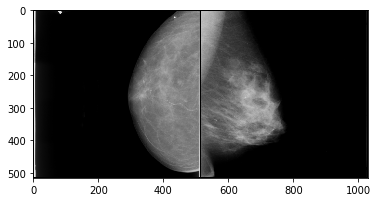

In [6]:
trainloader = val_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# test Dataset

MALIGNANT MALIGNANT


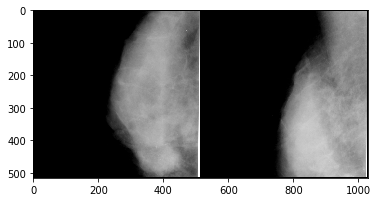

In [7]:
trainloader = test_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Get Model

In [8]:
model = B.getModel(3).to(device)

# store best prediction in one epoch

best_prec = 0


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [9]:
# See the architecture
print(model)

BaselineNet(
  (layer1): Sequential(
    (conv_1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1_1): ReLU()
    (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (conv_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2_1): ReLU()
    (conv_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxpool_3_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (conv_3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool_3_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [10]:
print(criterion)

CrossEntropyLoss()


In [11]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


# TensorBoard Logger

In [12]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs',comment="baseline")

In [13]:
def save_checkpoint(state,is_best,filename='./models/checkpoint.pth.tar'):
        torch.save(state,filename)
        if is_best:
            shutil.copyfile(filename,'./models/model_best.pth.tar')

In [14]:
def train(train_loader,model,criterion,optimizer,epoch,writer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()
    
    model.train()
    
    end = time.time()
    for i,(images,labels) in enumerate(train_loader):
        data_time.update(time.time()-end)
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output,labels)
        
        # top-k ? accuaracy 
        # for now evaluating normal accuracy
        acc = accuracy(output,labels)
        
        #loss.item() to get the loss value from loss tensor
        losses.update(loss.item(), images.size(0))
        avgaccu.update(acc,images.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        end = time.time()

        print('Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
              'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'.format(
               epoch, i, len(train_loader), batch_time=batch_time,
               data_time=data_time, loss=losses, acc=avgaccu))

In [15]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input=input.to(device)
            target =  target.to(device)
            
            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc= accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            avgaccu.update(acc,input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            print('Validation: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.3f} ({acc.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,acc=avgaccu))

        print(' * Acc {acc.avg:.3f}'
              .format(acc=avgaccu))

    return acc

In [16]:
def accuracy(output,target):
    with torch.no_grad():
        batch_size =  target.size(0)
        _, predicted = torch.max(output.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum().item()
        acc = correct/total
    return acc

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
def test(test_loader,model):

    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


# Training

In [ ]:

log_freq=10
for epoch in range(num_epochs):
    
    adjust_learning_rate(optimizer,epoch,learning_rate)
    
    
    train(train_loader,model,criterion,optimizer,epoch,writer)
    
    pause('')
    
    acc =  validate(val_loader,model,criterion)
    
    
    
    is_best = acc > best_acc
    
    best_acc = max(acc,best_acc)
    
    
    #saving the checkpoint if is_best is True
    save_checkpoint({
        'epoch':epoch+1,
        'state_dict':model.state_dict(),
        'best_acc':best_acc,
        'optimizer':optimizer.state_dict(),
    },is_best)
    
test(test_loader=test_loader,model=model)

Epoch: [0][0/29]	Time 3.636 (3.636)	Loss 1.1162 (1.1162)	Accuracy 0.0000 (0.0000)	
Epoch: [0][1/29]	Time 4.119 (3.877)	Loss 1.1266 (1.1214)	Accuracy 0.0000 (0.0000)	
Epoch: [0][2/29]	Time 3.994 (3.916)	Loss 1.1330 (1.1252)	Accuracy 0.0000 (0.0000)	
Epoch: [0][3/29]	Time 3.846 (3.899)	Loss 1.1041 (1.1200)	Accuracy 0.5000 (0.1250)	
Epoch: [0][4/29]	Time 4.060 (3.931)	Loss 1.0953 (1.1150)	Accuracy 0.5000 (0.2000)	
Epoch: [0][5/29]	Time 4.584 (4.040)	Loss 1.1095 (1.1141)	Accuracy 0.0000 (0.1667)	
Epoch: [0][6/29]	Time 4.147 (4.055)	Loss 1.0840 (1.1098)	Accuracy 1.0000 (0.2857)	
Epoch: [0][7/29]	Time 3.297 (3.960)	Loss 1.1060 (1.1093)	Accuracy 0.5000 (0.3125)	
Epoch: [0][8/29]	Time 3.721 (3.934)	Loss 1.1024 (1.1085)	Accuracy 0.0000 (0.2778)	
Epoch: [0][9/29]	Time 4.323 (3.973)	Loss 1.1002 (1.1077)	Accuracy 0.0000 (0.2500)	
Epoch: [0][10/29]	Time 4.177 (3.991)	Loss 1.0874 (1.1059)	Accuracy 0.5000 (0.2727)	
Epoch: [0][11/29]	Time 4.491 (4.033)	Loss 1.0863 (1.1042)	Accuracy 0.5000 (0.2917)	
Ep